In [ ]:
cfrom google.colab import drive
drive.mount('/content/drive')


In [1]:
import os

# Path to your dataset
DATASET_PATH = 'dataset/dataset'

# Path to save split datasets
BASE_OUTPUT_PATH = 'split_dataset'

# Output directories
TRAIN_DIR = os.path.join(BASE_OUTPUT_PATH, 'train')
VAL_DIR = os.path.join(BASE_OUTPUT_PATH, 'val')
TEST_DIR = os.path.join(BASE_OUTPUT_PATH, 'test')

# Create these directories
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for subdir in ['Authentic', 'Tampered']:
        os.makedirs(os.path.join(dir_path, subdir), exist_ok=True)


In [ ]:
import random
import shutil

# Set random seed for reproducibility
random.seed(42)

# Loop over each class
for class_name in ['Authentic', 'Tampered']:
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = os.listdir(class_dir)

    # Shuffle images
    random.shuffle(images)

    # Split indices
    num_images = len(images)
    train_split = int(0.9 * num_images)
    val_split = int(0.95 * num_images)

    # Copy images
    for idx, img in enumerate(images):
        src_path = os.path.join(class_dir, img)
        if idx < train_split:
            dest_dir = os.path.join(TRAIN_DIR, class_name)
        elif idx < val_split:
            dest_dir = os.path.join(VAL_DIR, class_name)
        else:
            dest_dir = os.path.join(TEST_DIR, class_name)

        shutil.copy2(src_path, dest_dir)


In [41]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import os

# Enable mixed precision and XLA
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

# Paths and constants
train_dir = 'split_dataset/train'
test_dir = 'split_dataset/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# === 1. Create ImageDataGenerators ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# === 2. Load the datasets from directory ===
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 138900 images belonging to 2 classes.
Found 7718 images belonging to 2 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Conv2D
from tensorflow.keras.models import Sequential

class HybridSECBAM(Layer):
    def __init__(self, se_ratio=16, cbam_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.se_ratio = se_ratio
        self.cbam_ratio = cbam_ratio

    def get_config(self):
        config = super().get_config()
        config.update({
            'se_ratio': self.se_ratio,
            'cbam_ratio': self.cbam_ratio,
        })
        return config

    def build(self, input_shape):
        channels = input_shape[-1]
        
        # SE layers
        self.se_dense1 = Dense(channels // self.se_ratio, activation='swish')
        self.se_dense2 = Dense(channels, activation='sigmoid')

        # CBAM channel attention MLP (shared for avg and max)
        self.channel_mlp = Sequential([
            Dense(channels // self.cbam_ratio, activation='swish'),
            Dense(channels)
        ])
        
        # CBAM spatial attention
        self.spatial_conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
      dtype = inputs.dtype  # Match all tensors to this dtype

       # --- SE ---
      se = tf.reduce_mean(inputs, axis=[1, 2])
      se = self.se_dense1(se)
      se = self.se_dense2(se)
      se = tf.reshape(se, [-1, 1, 1, inputs.shape[-1]])
      se = tf.cast(se, dtype)

      # --- CBAM Channel Attention ---
      avg_pool = tf.reduce_mean(inputs, axis=[1, 2])
      max_pool = tf.reduce_max(inputs, axis=[1, 2])
      channel_att = tf.nn.sigmoid(self.channel_mlp(avg_pool) + self.channel_mlp(max_pool))
      channel_att = tf.reshape(channel_att, [-1, 1, 1, inputs.shape[-1]])
      channel_att = tf.cast(channel_att, dtype)

      # --- CBAM Spatial Attention ---
      avg_pool_spatial = tf.reduce_mean(inputs, axis=-1, keepdims=True)
      max_pool_spatial = tf.reduce_max(inputs, axis=-1, keepdims=True)
      concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)
      spatial_att = self.spatial_conv(concat)
      spatial_att = tf.cast(spatial_att, dtype)

      # --- Combine ---
      out = inputs * se * channel_att * spatial_att
      return out



In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import GroupNormalization
from tensorflow.keras import layers

class EnhancedMHABlock(Layer):
    def __init__(self, num_heads=8, key_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim

    def build(self, input_shape):
        channels = input_shape[-1]
        if channels is None:
            raise ValueError("Input channels must be defined.")

        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.key_dim,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros'
        )

        self.ffn = Sequential([
            Conv2D(4 * channels, kernel_size=1, activation='swish'),
            Conv2D(channels, kernel_size=1)
        ])

        def get_valid_group_count(ch):
            for g in reversed(range(1, 33)):
                if ch % g == 0:
                    return g
            return 1

        group_count = get_valid_group_count(channels)

        self.norm1 = GroupNormalization(groups=group_count)
        self.norm2 = GroupNormalization(groups=group_count)

    def call(self, inputs):
       dtype = inputs.dtype  # Consistently use the same dtype throughout

       shape = tf.shape(inputs)
       B, H, W, C = shape[0], shape[1], shape[2], shape[3]

       x_flat = tf.reshape(inputs, [B, H * W, C])
       attn = self.mha(x_flat, x_flat)
       attn = tf.reshape(attn, [B, H, W, C])
       attn = tf.cast(attn, dtype)

       x = self.norm1(inputs + attn)
       ffn_out = self.ffn(x)
       return self.norm2(x + ffn_out)


    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config


C:\Users\vikas\Desktop\PR - Project\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\vikas\Desktop\PR - Project\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [4]:
from keras.applications import EfficientNetB7
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision
import tensorflow as tf

def build_enhanced_model(img_size=(300, 300), num_classes=1):
    base_model = EfficientNetB7(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )

    # Feature extraction
    block3_output = base_model.get_layer('block3a_project_bn').output
    block5_output = base_model.get_layer('block5a_project_bn').output

    # Attention pipeline
    x3 = HybridSECBAM()(block3_output)
    x3 = EnhancedMHABlock()(x3)
    x3 = layers.MaxPooling2D(pool_size=2)(x3)

    x5 = HybridSECBAM()(block5_output)
    x5 = EnhancedMHABlock()(x5)

    x = layers.Concatenate()([x3, x5])

    max_pool = layers.GlobalMaxPooling2D()(x)
    avg_pool = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([max_pool, avg_pool])

    x = layers.Dense(512, activation='swish', dtype='float32')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='swish', dtype='float32')(x)
    output = layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    return model


# Step 1: Make sure mixed precision is NOT enabled before model creation
mixed_precision.set_global_policy('float32')

# Step 2: Build the model
model = build_enhanced_model(img_size=(224, 224), num_classes=1)

# Step 3: Enable mixed precision globally (only after model is built)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Step 4: Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2050, compute capability 8.6
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [6]:
import math
import scipy
import scipy.ndimage  # <- This fixes the error
from tensorflow.keras import callbacks

EPOCHS = 50

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.3,
        patience=3,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
    callbacks.TensorBoard(
        log_dir='logs/fit',
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
]

# === Model Training ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callback_list,
    class_weight=class_weights_dict if 'class_weights_dict' in locals() else None,
    verbose=1
)


Epoch 1/50
8682/8682 [==============================] - 4941s 557ms/step - loss: 0.1569 - accuracy: 0.9290 - auc: 0.9847 - precision: 0.9282 - recall: 0.9276 - val_loss: 0.1734 - val_accuracy: 0.9285 - val_auc: 0.9887 - val_precision: 0.9578 - val_recall: 0.8943 - lr: 1.0000e-04
Epoch 2/50
8682/8682 [==============================] - 4888s 563ms/step - loss: 0.0734 - accuracy: 0.9681 - auc: 0.9964 - precision: 0.9622 - recall: 0.9735 - val_loss: 0.0489 - val_accuracy: 0.9788 - val_auc: 0.9985 - val_precision: 0.9703 - val_recall: 0.9871 - lr: 1.0000e-04
Epoch 3/50
8682/8682 [==============================] - 4814s 555ms/step - loss: 0.0585 - accuracy: 0.9752 - auc: 0.9975 - precision: 0.9680 - recall: 0.9822 - val_loss: 0.0508 - val_accuracy: 0.9775 - val_auc: 0.9983 - val_precision: 0.9741 - val_recall: 0.9803 - lr: 1.0000e-04
Epoch 4/50
8682/8682 [==============================] - 4816s 555ms/step - loss: 0.0495 - accuracy: 0.9791 - auc: 0.9982 - precision: 0.9727 - recall: 0.9852 - 

In [ ]:
import math
import scipy
import scipy.ndimage  # <- This fixes the error
import tensorflow_addons as tfa
from tensorflow.keras import callbacks

EPOCHS = 50

# --- 1) Enhanced Callbacks for Fine-Tuning ---
fine_tune_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=7,  # Increased patience for fine-tuning
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,  # More gradual LR reduction
        patience=2,
        mode='max',
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model_finetuned.h5',
        monitor='val_auc',
        mode='max',
        save_weights_only=True,  # Space-efficient
        save_best_only=True,
        verbose=1
    )
    # Note: AverageModelCheckpoint and TimeStampedWeights are not available in current TFA,
    # you may implement SWA manually if needed.
]

# --- 2) Strategic Layer Unfreezing ---
base_model.trainable = True

# Unfreeze blocks 6 and 7 (optimal for EfficientNet fine-tuning)
for layer in base_model.layers:
    if 'block6' in layer.name or 'block7' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# --- 3) Advanced Compilation ---
optimizer = tfa.optimizers.AdamW(
    learning_rate=1e-5,
    weight_decay=1e-4,  # Added weight decay
    global_clipnorm=1.0  # Gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', curve='PR'),  # Precision-Recall AUC
        tfa.metrics.F1Score(num_classes=1, threshold=0.5),
        tf.keras.metrics.PrecisionAtRecall(0.9)  # High-recall requirement
    ]
)

# --- 4) Optimized Fine-Tuning ---
history = model.fit(
    train_gen,
    steps_per_epoch=math.ceil(train_gen.samples / BATCH_SIZE),
    validation_data=val_gen,
    validation_steps=math.ceil(val_gen.samples / BATCH_SIZE),
    epochs=EPOCHS + 15,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict if 'class_weights_dict' in locals() else None,
    verbose=1
)



Epoch 1/65


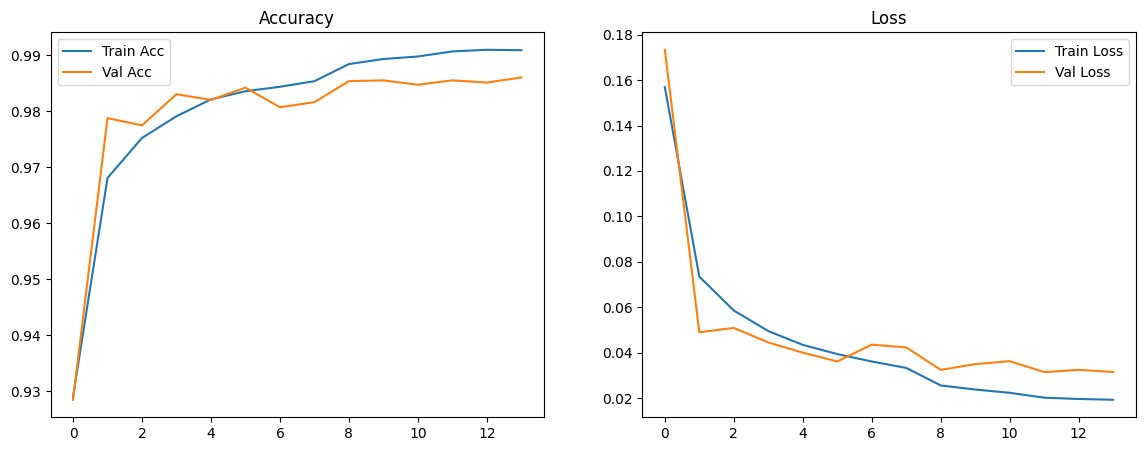

In [10]:
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')

    plt.show()

plot_history(history)


Found 7717 images belonging to 2 classes.
483/483 [==============================] - 61s 127ms/step
              precision    recall  f1-score   support

  Authorised       0.99      0.98      0.99      3915
      Forged       0.98      0.99      0.99      3802

    accuracy                           0.99      7717
   macro avg       0.99      0.99      0.99      7717
weighted avg       0.99      0.99      0.99      7717



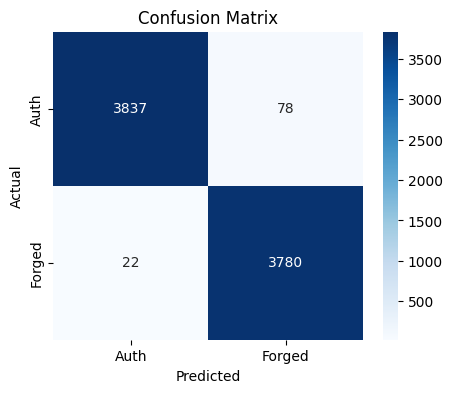

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# 1. Predict on test set
val_dir = 'split_dataset/val'
test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# 2. True labels
test_labels_encoded = test_generator.classes

# 3. Convert probabilities to class labels (0 or 1)
y_pred_labels = (test_predictions.squeeze() > 0.5).astype(int)

# 4. Print classification report
print(classification_report(test_labels_encoded, y_pred_labels,
                            target_names=['Authorised','Forged']))

# 5. Confusion matrix heatmap
cm = confusion_matrix(test_labels_encoded, y_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Auth','Forged'], yticklabels=['Auth','Forged'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


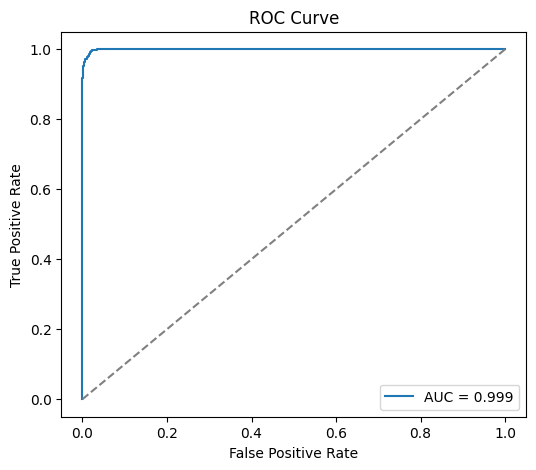

In [22]:
from sklearn.metrics import roc_curve, auc

# `test_predictions` should be your model’s output probabilities
fpr, tpr, thresholds = roc_curve(test_labels_encoded, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [64]:
model.save_weights('model_weights.h5')  # Always works


In [ ]:
model.save('my_model.keras')


In [6]:
from tensorflow.keras.models import load_model

model = load_model('model.h5', custom_objects={
    'HybridSECBAM': HybridSECBAM,
    'EnhancedMHABlock': EnhancedMHABlock
})


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
img_path = 'This-is-not-a-person-2-1.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Match input size
img_array = image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Preprocess
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction1 = model.predict(img_array)
print("Prediction:", prediction1)


1/1 [==============================] - 0s 76ms/step
Prediction: [[0.99975556]]


In [16]:
label = (prediction1 > 0.5).astype(int)
print("Predicted Label:", "forged" if label == 1 else "authentic")


Predicted Label: forged


In [44]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
img_path = 'aapnvogymq_105_0.png'
img = image.load_img(img_path, target_size=(224, 224))  # Match input size
img_array = image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Preprocess
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img_array)
print("Prediction:", prediction)


1/1 [==============================] - 23s 23s/step
Prediction: [[3.0840898e-08]]


In [45]:
label = (prediction > 0.5).astype(int)
print("Predicted Label:", "forged" if label == 1 else "authentic")


Predicted Label: authentic


Found 7718 images belonging to 2 classes.
483/483 [==============================] - 177s 367ms/step
              precision    recall  f1-score   support

  Authorised       0.99      0.98      0.99      3915
      Forged       0.98      0.99      0.99      3803

    accuracy                           0.99      7718
   macro avg       0.99      0.99      0.99      7718
weighted avg       0.99      0.99      0.99      7718



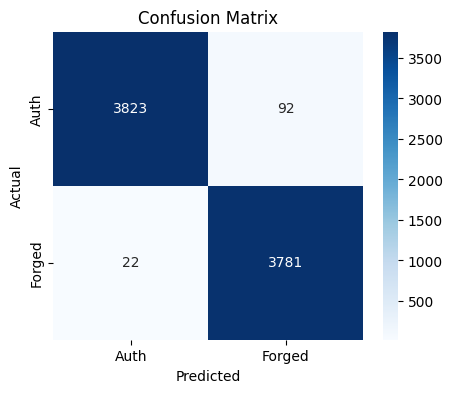

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# 1. Predict on test set
val_dir = 'split_dataset/test'
test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# 2. True labels
test_labels_encoded = test_generator.classes

# 3. Convert probabilities to class labels (0 or 1)
y_pred_labels = (test_predictions.squeeze() > 0.5).astype(int)

# 4. Print classification report
print(classification_report(test_labels_encoded, y_pred_labels,
                            target_names=['Authorised','Forged']))

# 5. Confusion matrix heatmap
cm = confusion_matrix(test_labels_encoded, y_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Auth','Forged'], yticklabels=['Auth','Forged'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
